<a href="https://colab.research.google.com/github/kate-simonova/cancer-subtyping/blob/main/02_functional_spectra_split_separation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # DL based models for cancer subtype identification

**Two main considerations:**

* we deal with multilabel dataset, so all labels should be present in the same proprtion in every set (training, testing)
* the data should not be simillar to each other in test and train set, other wise the accuracy will be so high

## Data Loading and installation of packages

In [ ]:
pip install -U kaleido

In [ ]:
# importing necessary packages
import re
import os
import pandas as pd
import numpy as np
import kaleido 
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from tensorflow import keras
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
import plotly.express as px

# constants
path_crc = "/home/simonova/Colorectal_cancer/FS"
path_brca = "/home/simonova/Breast_cancer/FS"
path = "/home/simonova/merged"

In [ ]:
# functions used in script
def plot_pie(df, string):
  """
  this function is used to visualize the data
  """
  freq = [round(i*100,1) for i in df.value_counts(normalize=True).tolist()]
  lbl = df.value_counts(normalize=True).index.tolist()
  fig1, ax1 = plt.subplots(figsize=(7,7))
  ax1.pie(freq, labels=lbl, autopct='%1.0f%%', shadow=False, startangle=90, pctdistance=0.7, rotatelabels=True)
  ax1.text(-1,1, f'{string}', fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round')) 
  plt.show()

def show_values_on_bars(axs):
  '''
  this finction is used to plot lables
  '''
  def _show_on_single_plot(ax):
      for p in ax.patches:
          _x = p.get_x() + p.get_width() / 2
          _y = p.get_y() + p.get_height() 
          value = '{:.0f}'.format(p.get_height())
          ax.text(_x, _y + 20, value, ha="center", fontsize=16)

  if isinstance(axs, np.ndarray):
      for idx, ax in np.ndenumerate(axs):
          _show_on_single_plot(ax)
  else:
      _show_on_single_plot(axs)

def scale_pca(df):
  """
  this function is used to prepare data for visualization with PCA
  """
  X_scaled_df = StandardScaler().fit_transform(df)
  X_scaled_df = pd.DataFrame(X_scaled_df,columns=df.columns)

  pca = PCA()
  components = pca.fit_transform(X_scaled_df)
  labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }
  return (components, labels)

def values(row):
  '''
  this function is used to calculate a circle
  '''
  r2 = row["PC1"]**2 + row["PC2"]**2 
  r = np.sqrt(r2)
  return "Train" if r <= 110 else "Test"

## Merging BRCA and CRC

In [ ]:
# loading colorectal cancer dataset
crc_df = pd.read_csv(f"{path_crc}/crc_fs_final.csv.zip", compression="zip", index_col=0)
crc_meta = pd.read_csv(f"{path_crc}/crc_metadata.csv.zip", compression="zip", index_col=0)
crc_df = crc_df.loc[crc_meta["Sample"], :]
crc_meta["Cancer"] = "Colorectal"
crc_meta.shape

(2436, 6)

In [ ]:
# loading breast cancer dataset
brca_df = pd.read_csv(f"{path_brca}/brca_fs_final.csv.zip", compression="zip", index_col=0)
brca_meta = pd.read_csv(f"{path_brca}/metadata_breast_combined.csv.zip", compression="zip", index_col=0)
brca_df = brca_df.loc[brca_meta["Sample ID"], :]
brca_meta["Cancer"] = "Breast"
brca_meta.shape

(11264, 6)

In [ ]:
crc_meta.columns = brca_meta.columns = ["Sample ID", "Label", "Study ID", "Platform", "Normalization", "Cancer"]

In [ ]:
metadata = crc_meta.append(brca_meta)
metadata.shape

/tmp/ipykernel_16052/31895010.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metadata = crc_meta.append(brca_meta)


In [ ]:
merged_df = crc_df.append(brca_df)
merged_df.shape

/tmp/ipykernel_16052/2431230042.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_df = crc_df.append(brca_df)


(13700, 22596)

In [ ]:
#metadata.to_csv(f"{path}/metadata_combined.csv.zip", compression="zip")
#merged_df.to_csv(f"{path}/counts_combined.csv.zip", compression="zip", index=True)

### Final PCA

In [ ]:
metadata = pd.read_csv(f"{path}/metadata_combined.csv.zip", compression="zip")
merged_df = pd.read_csv(f"{path}/counts_combined.csv.zip", compression="zip", index_col=0)

In [ ]:
comp_both, labels_both = scale_pca(merged_df)

In [ ]:
fig = px.scatter_matrix(
    comp_both,
    labels=labels_both,
    dimensions=range(4),
    color = metadata["Label"]
)

fig.layout.legend.y = 1.05
fig.layout.legend.x = 1.035

fig.update_traces(marker={'size': 2})

fig.update_layout(legend= {'itemsizing': 'constant'})
fig.update_traces(diagonal_visible=False)
fig.write_image(f"{path}/img/Label_PCA.svg")
fig.show()

/home/simonova/.local/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  dims = [
/mnt/foibe3/Users/simonova/conda/envs/jup_env/lib/python3.10/site-packages/google/colab/data_table.py:30: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



In [ ]:
fig = px.scatter_matrix(
    comp_both,
    labels=labels_both,
    dimensions=range(4),
    color = metadata["Cancer"]
)

fig.layout.legend.y = 1.05
fig.layout.legend.x = 1.035
fig.update_traces(marker={'size': 2})

fig.update_layout(legend= {'itemsizing': 'constant'})
fig.update_traces(diagonal_visible=False)
fig.write_image(f"{path}/img/Cancer_PCA.svg")

fig.show()

/home/simonova/.local/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [ ]:
fig = px.scatter_matrix(
    comp_both,
    labels=labels_both,
    dimensions=range(4),
    color = metadata["Normalization"]
)

fig.layout.legend.y = 1.05
fig.layout.legend.x = 1.035
fig.update_traces(marker={'size': 2})

fig.update_layout(legend= {'itemsizing': 'constant'})
fig.update_traces(diagonal_visible=False)
fig.write_image(f"{path}/img/Normalization_PCA.svg")
fig.show()

/home/simonova/.local/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [ ]:
fig = px.scatter_matrix(
    comp_both,
    labels=labels_both,
    dimensions=range(4),
    color = metadata["Platform"]
)

fig.layout.legend.y = 1.05
fig.layout.legend.x = 1.035
fig.update_traces(marker={'size': 2})

fig.update_layout(legend= {'itemsizing': 'constant'})
fig.update_traces(diagonal_visible=False)
fig.write_image(f"{path}/img/Platform_PCA.svg")

fig.show()

/home/simonova/.local/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



## Separation to training and testing data

In [ ]:
components = pd.DataFrame(comp_both)
cps = components[[0,1]]
cps.index = merged_df.index
cps.columns = ["PC1", "PC2"]
cps.head()

PC1        PC2
GSM820048 -133.412434 -59.483402
GSM820049  -61.082121 -72.363589
GSM820050 -123.489530 -78.593613
GSM820051 -117.945732 -68.997548
GSM820052  -82.893201 -78.505106

In [ ]:
cps["Train_test"] = cps.apply(values, axis=1)
cps.head()

/tmp/ipykernel_16052/2023599829.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



PC1        PC2 Train_test
GSM820048 -133.412434 -59.483402       Test
GSM820049  -61.082121 -72.363589      Train
GSM820050 -123.489530 -78.593613       Test
GSM820051 -117.945732 -68.997548       Test
GSM820052  -82.893201 -78.505106       Test

In [ ]:
cps["Train_test"].value_counts()

Train    11544
Test      2156
Name: Train_test, dtype: int64

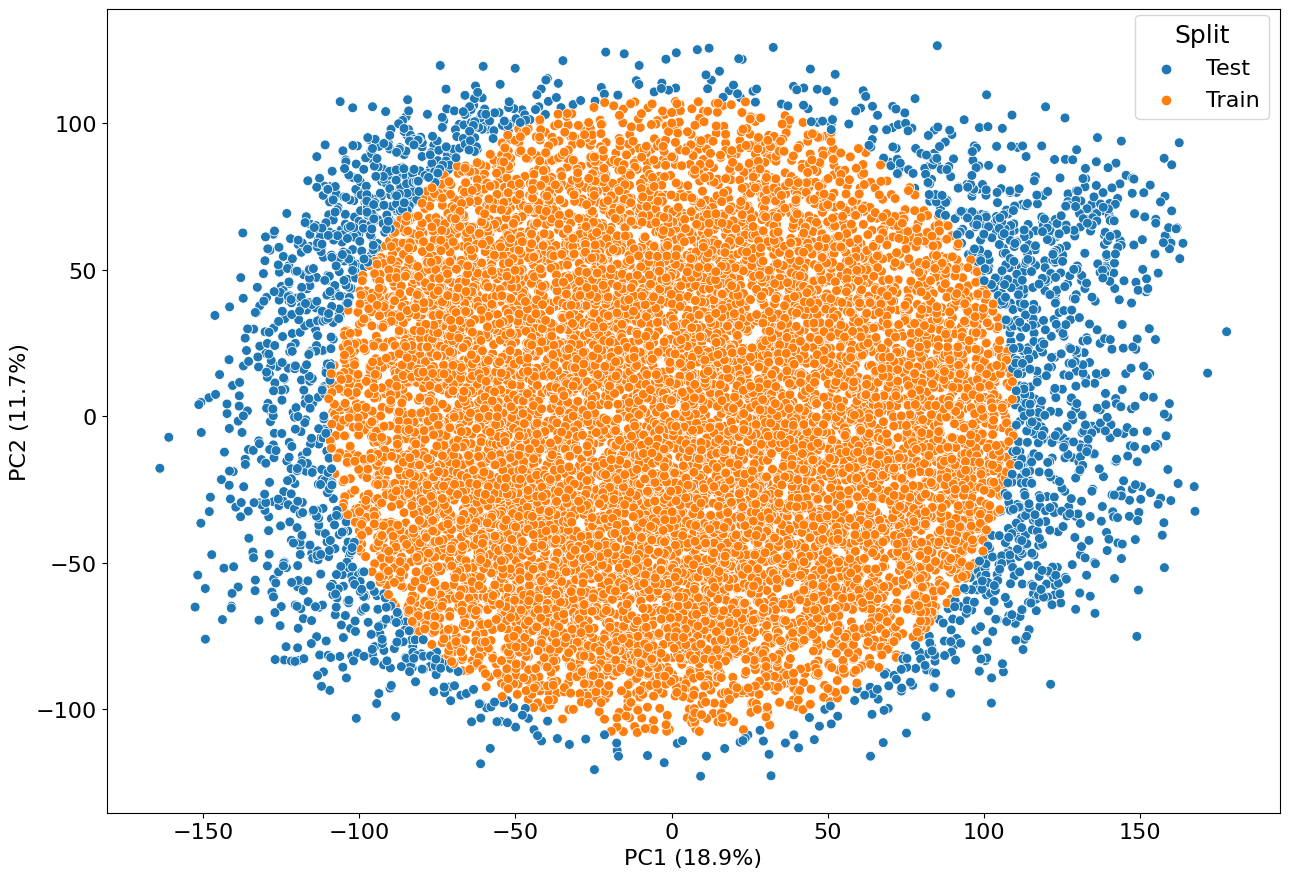

In [ ]:
plt.figure(figsize=(13,9))
components_df = pd.DataFrame(comp_both)
components_df.columns = [f"PC{i+1}" for i in components_df.columns]
components_df.index = cps.index
c_df = pd.merge(components_df, cps, left_index=True, right_index=True, how="left")

sns.scatterplot(x="PC1", y="PC2", s=50, hue="Train_test", data=cps)
plt.xlabel("PC1 (18.9%)", fontsize=16)
plt.ylabel("PC2 (11.7%)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(prop={'size': 16}, title="Split",title_fontsize=18, bbox_to_anchor=(0.1, 0.85, 0.9, 0.9), loc="lower right", ncol=1)

plt.tight_layout()
plt.savefig(f"{path}/img/merged_split_DeepCC.pdf", format="pdf")
plt.show()

### Separation on training and testing data

In [ ]:
y_train_index = pd.DataFrame(cps[cps["Train_test"] == True].index)
y_text_index = pd.DataFrame(cps[cps["Train_test"] == False].index)
y_train_index.columns = ["ID"]
y_text_index.columns = ["ID"]

In [ ]:
 y_train = pd.merge(y_train_index, metadata, left_on="ID", right_on="Sample ID", how="left")

In [ ]:
 y_test = pd.merge(y_text_index, metadata, left_on="ID", right_on="Sample ID", how="left")

In [ ]:
round(y_train["Label"].value_counts(normalize=True)*100,2)

Series([], Name: Label, dtype: float64)

In [ ]:
round(y_test["Label"].value_counts(normalize=True)*100,2)

Series([], Name: Label, dtype: float64)

In [ ]:
b = y_train["Label"].value_counts(normalize=True).rename_axis('unique_values').reset_index(name='train')
a = y_test["Label"].value_counts(normalize=True).rename_axis('unique_values').reset_index(name='test')
relative_change = pd.merge(a,b, left_on="unique_values", right_on="unique_values", how="inner")
relative_change["Diff %"] = (relative_change["test"] - relative_change["train"])*100
relative_change

Empty DataFrame
Columns: [test, unique_values, train, Diff %]
Index: []

In [ ]:
# creating a new metadata file
cps = cps.reset_index()
meta = pd.merge(cps, metadata, left_on="index", right_on="Sample ID", how="left")
meta = meta.drop(["index", "PC1", "PC2", "Unnamed: 0"], axis=1)
meta["Train_test"] = meta["Train_test"].replace(True, "Train")
meta["Train_test"] = meta["Train_test"].replace(False, "Test")
meta

Train_test  Sample ID      Label   Study ID               Platform  \
0           Test  GSM820048       CMS2   gse33113  Affymetrix HG133plus2   
1          Train  GSM820049       CMS2   gse33113  Affymetrix HG133plus2   
2           Test  GSM820050       CMS1   gse33113  Affymetrix HG133plus2   
3           Test  GSM820051       CMS1   gse33113  Affymetrix HG133plus2   
4           Test  GSM820052       CMS2   gse33113  Affymetrix HG133plus2   
...          ...        ...        ...        ...                    ...   
13695      Train  GE0089198       Her2  GSE135298         RNA sequencing   
13696       Test  GE0089201  Luminal B  GSE135298         RNA sequencing   
13697      Train  GE0089203  Luminal A  GSE135298         RNA sequencing   
13698      Train  GE0089204  Luminal B  GSE135298         RNA sequencing   
13699      Train  GE0089207  Luminal B  GSE135298         RNA sequencing   

      Normalization      Cancer  
0              fRMA  Colorectal  
1              fRMA  Colorectal  
2              fRMA  Colorectal  
3              fRMA  Colorectal  
4              fRMA  Colorectal  
...             ...         ...  
13695          FPKM      Breast  
13696          FPKM      Breast  
13697          FPKM      Breast  
13698          FPKM      Breast  
13699          FPKM      Breast  

[13700 rows x 7 columns]

In [ ]:
sdf = meta.groupby(["Label", "Train_test"])["Sample ID"].count().reset_index()
sdf.head()

Label Train_test  Sample ID
0  Basal-like       Test        118
1  Basal-like      Train       1654
2        CMS1       Test        134
3        CMS1      Train        286
4        CMS2       Test        285

In [ ]:
sdf.to_csv(f"{path}/table.csv", index=True)

### Distribution of labels

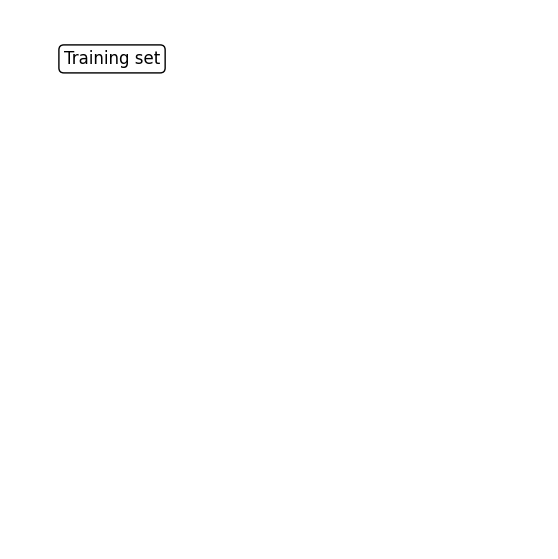

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_pie(y_train["Label"], "Training set")
plt.tight_layout()

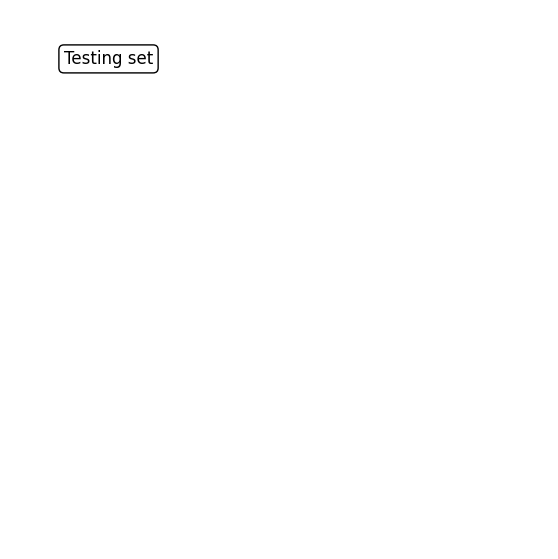

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_pie(y_test["Label"], "Testing set")
plt.tight_layout()

In [ ]:
y_train = meta[meta["Train_test"] == "Train"]
y_test = meta[meta["Train_test"] != "Train"]

X_train = merged_df.T[y_train["Sample ID"]]
X_test = merged_df.T[y_test["Sample ID"]]

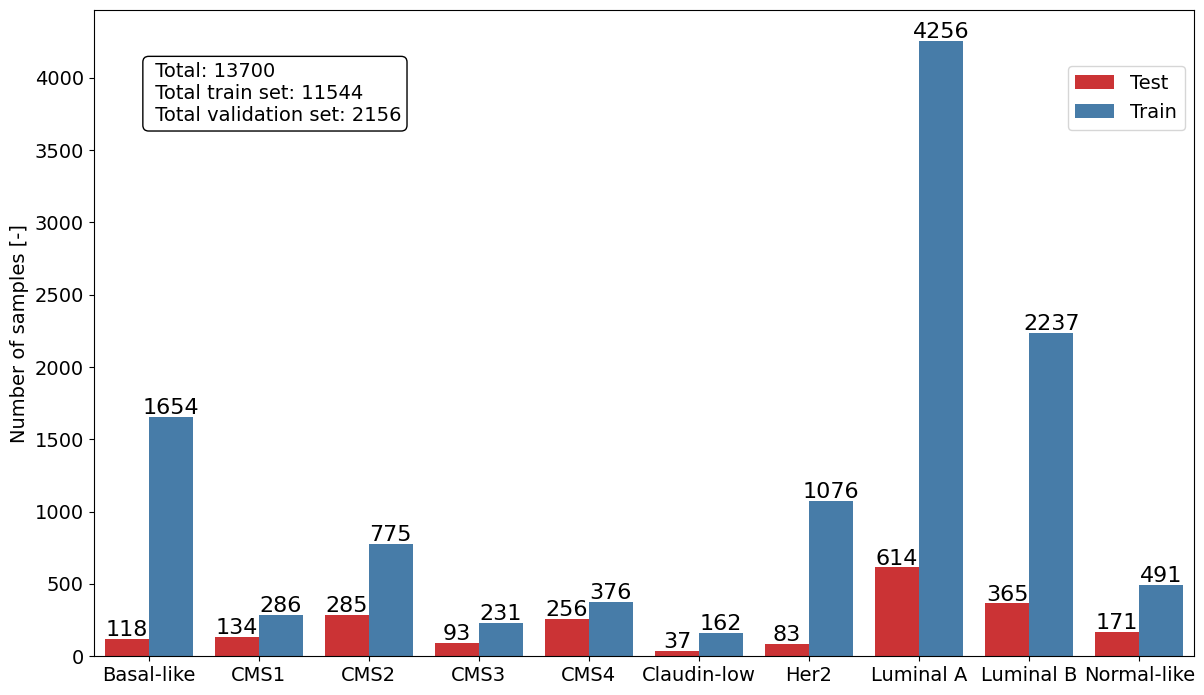

In [ ]:
plt.figure(figsize=(12,7))

ax = sns.barplot(x='Label', y='Sample ID', hue='Train_test', data=sdf, palette='Set1')
ax.set_ylabel("Number of samples [-]", fontsize=14),
ax.set_xlabel("", fontsize=14)
#ax.set_title("Label counts of train/validation set")
plt.tight_layout()
ax.legend(prop={'size': 14}, bbox_to_anchor=(0.1, 0.8, 0.9, 0.8), loc="lower right", ncol=1)
ax.tick_params(axis='x', which='major', labelsize=14)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.text(0, 3700, f" Total: {meta.shape[0]}\n Total train set: {y_train.shape[0]}\n Total validation set: {y_test.shape[0]}",fontsize=14, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
show_values_on_bars(ax)
plt.savefig(f"{path}/img/Split.pdf", format="pdf")

In [ ]:
X_test.shape

(22596, 2156)

In [ ]:
X_train.shape

(22596, 11544)

In [ ]:
y_train.head()

Train_test  Sample ID       Label   Study ID               Platform  \
1          Train  GSM820049        CMS2   gse33113  Affymetrix HG133plus2   
18         Train  GSM820066        CMS3   gse33113  Affymetrix HG133plus2   
21         Train  GSM820069        CMS3   gse33113  Affymetrix HG133plus2   
22         Train  GSM820070        CMS2   gse33113  Affymetrix HG133plus2   
29         Train  GSM820078        CMS2   gse33113  Affymetrix HG133plus2   
...          ...        ...         ...        ...                    ...   
13692      Train  GE0089195  Basal-like  GSE135298         RNA sequencing   
13695      Train  GE0089198        Her2  GSE135298         RNA sequencing   
13697      Train  GE0089203   Luminal A  GSE135298         RNA sequencing   
13698      Train  GE0089204   Luminal B  GSE135298         RNA sequencing   
13699      Train  GE0089207   Luminal B  GSE135298         RNA sequencing   

      Normalization      Cancer  
1              fRMA  Colorectal  
18             fRMA  Colorectal  
21             fRMA  Colorectal  
22             fRMA  Colorectal  
29             fRMA  Colorectal  
...             ...         ...  
13692          FPKM      Breast  
13695          FPKM      Breast  
13697          FPKM      Breast  
13698          FPKM      Breast  
13699          FPKM      Breast  

[11544 rows x 7 columns]

In [ ]:
X_train.head()

GSM820049  GSM820066  GSM820069  \
AAACCAC_MIR140                               0.450271   0.340757   0.334289   
AAAGACA_MIR511                               0.431473   0.324600   0.341277   
AAAGGAT_MIR501                               0.487654   0.385200   0.393823   
AAAGGGA_MIR204_MIR211                        0.398351   0.355456   0.308953   
AAANWWTGC_UNKNOWN                            0.291338   0.335538  -0.256886   
...                                               ...        ...        ...   
ZWANG_EGF_INTERVAL_DN                        0.304326   0.335133   0.370212   
ZWANG_EGF_INTERVAL_UP                        0.283429   0.214030  -0.265518   
ZWANG_EGF_PERSISTENTLY_DN                    0.292673   0.341190   0.398325   
ZWANG_EGF_PERSISTENTLY_UP                    0.488532   0.470013  -0.426994   
ZWANG_TRANSIENTLY_UP_BY_2ND_EGF_PULSE_ONLY   0.171926   0.232676  -0.203416   

                                            GSM820070  GSM820078  GSM820084  \
AAACCAC_MIR140                               0.378107   0.446235   0.407305   
AAAGACA_MIR511                               0.387896   0.309998   0.407341   
AAAGGAT_MIR501                               0.371458   0.345652   0.352923   
AAAGGGA_MIR204_MIR211                        0.256488   0.328518   0.346328   
AAANWWTGC_UNKNOWN                           -0.400291   0.275641   0.368392   
...                                               ...        ...        ...   
ZWANG_EGF_INTERVAL_DN                        0.246760   0.280380   0.309353   
ZWANG_EGF_INTERVAL_UP                        0.207216   0.319538   0.258065   
ZWANG_EGF_PERSISTENTLY_DN                    0.253141   0.277596   0.438451   
ZWANG_EGF_PERSISTENTLY_UP                    0.291606   0.405652   0.341259   
ZWANG_TRANSIENTLY_UP_BY_2ND_EGF_PULSE_ONLY  -0.227856   0.193382   0.255630   

                                            GSM820086  GSM820087  GSM820089  \
AAACCAC_MIR140                               0.402621   0.453879  -0.236501   
AAAGACA_MIR511                               0.374760   0.431708   0.267224   
AAAGGAT_MIR501                               0.305660   0.467558   0.239037   
AAAGGGA_MIR204_MIR211                        0.347988   0.420632   0.329659   
AAANWWTGC_UNKNOWN                            0.244821   0.482343   0.231199   
...                                               ...        ...        ...   
ZWANG_EGF_INTERVAL_DN                        0.325520   0.368303   0.304058   
ZWANG_EGF_INTERVAL_UP                        0.322286  -0.204545   0.199437   
ZWANG_EGF_PERSISTENTLY_DN                    0.360243   0.393010   0.409892   
ZWANG_EGF_PERSISTENTLY_UP                    0.373659   0.404379   0.379468   
ZWANG_TRANSIENTLY_UP_BY_2ND_EGF_PULSE_ONLY  -0.187323   0.252536  -0.185166   

                                            GSM820092  ...  GE0089184  \
AAACCAC_MIR140                               0.220577  ...   0.281080   
AAAGACA_MIR511                               0.297634  ...   0.417422   
AAAGGAT_MIR501                               0.303738  ...   0.273602   
AAAGGGA_MIR204_MIR211                        0.318258  ...   0.334086   
AAANWWTGC_UNKNOWN                            0.308983  ...  -0.218118   
...                                               ...  ...        ...   
ZWANG_EGF_INTERVAL_DN                        0.442150  ...   0.279701   
ZWANG_EGF_INTERVAL_UP                        0.241623  ...  -0.231149   
ZWANG_EGF_PERSISTENTLY_DN                    0.383161  ...   0.360746   
ZWANG_EGF_PERSISTENTLY_UP                    0.531788  ...   0.420183   
ZWANG_TRANSIENTLY_UP_BY_2ND_EGF_PULSE_ONLY   0.341779  ...   0.267078   

                                            GE0089185  GE0089188  GE0089121  \
AAACCAC_MIR140                              -0.256637  -0.379079   0.429832   
AAAGACA_MIR511                              -0.275530  -0.390767   0.414373   
AAAGGAT_MIR501                              -0.310855  -0.328627   0.491784   
AAAG

### Saving file

In [ ]:
X_train.to_csv(f"{path}/split_circle/X_train_A_merged_CRC_BRCA.csv.tar.gz", compression = "gzip")
y_train.to_csv(f"{path}/split_circle/y_train_A_merged_CRC_BRCA.csv.tar.gz", compression = "gzip")
X_test.to_csv(f"{path}/split_circle/X_test_A_merged_CRC_BRCA.csv.tar.gz", compression = "gzip")
y_test.to_csv(f"{path}/split_circle/y_test_A_merged_CRC_BRCA.csv.tar.gz", compression = "gzip")